In [50]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import os

from collections import Counter
from tqdm import tqdm
from hanspell import spell_checker
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import warnings
# 경고메세지 끄기
warnings.filterwarnings(action='ignore')
import matplotlib.font_manager as fm
fontlist = fm.findSystemFonts(fontpaths=None, fontext='ttf')
fontlist
path = '/usr/share/fonts/truetype/nanum/NanumSquareR.ttf' # fontlist에 있던 경로입니다
font_name = fm.FontProperties(fname=path).get_name()
font_name
plt.rcParams['font.family'] =font_name
plt.rcParams['axes.unicode_minus'] =False


In [51]:
train_df=pd.read_csv('../data/train_spelling_v2_label_v1.csv')

In [52]:
# !pip install googletrans==3.1.0a0

In [53]:
import googletrans
trans = googletrans.Translator()
ex = '日, 특징주 엘리엇 재압박에 中 현대차 그룹株 등락 엇갈려 北'
ex = '서울올림픽 문화적 자취를 찾다…화합과 전진 展'
ex = '하나금융 광주에 직장어린이집 열어…中企 직원자녀도 이용'
ex_en = trans.translate(ex,dest='en')
print(ex_en.text)
ex_ko = trans.translate(ex_en.text,dest='ko')
print(ex_ko.text)

Hana Financial Group opened a workplace daycare center in Gwangju…中企 Employees' children also use
하나금융그룹, 광주에 직장 어린이집 개원…中企 임직원 자녀도 이용


In [54]:
import googletrans
trans = googletrans.Translator()
train_bt = train_df.copy()
train_bt = train_bt.head()
train_bt

,Unnamed: 0,ID,text,target,url,date
0,0,ynat-v1_train_00000,유튜브 내달 2일까지 크리에이터 지원 공간 운영,3,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=105&sid2=227&oid=001&aid=0008508947,2016.06.30. 오전 10:36
1,1,ynat-v1_train_00001,어버이날 맑다가 흐려져…남부지방 옅은 황사,3,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=103&sid2=248&oid=001&aid=0008384783,2016.05.08. 오전 5:25
2,2,ynat-v1_train_00002,내년부터 국가RD 평가 때 논문건수는 반영 않는다,2,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=105&sid2=228&oid=001&aid=0008254585,2016.03.15. 오후 12:00
3,3,ynat-v1_train_00003,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것,2,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=105&sid2=228&oid=001&aid=0009070646,2017.02.28. 오전 9:54
4,4,ynat-v1_train_00004,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간,3,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=103&sid2=243&oid=001&aid=0009999529,2018.04.03. 오전 7:05


## 한자 대치

In [55]:
ex=train_df.copy()
ex = train_df[train_df['text'].str.contains('中企')]
ex.head(2)

,Unnamed: 0,ID,text,target,url,date
9708,9708,ynat-v1_train_09708,中企경기전망지수 3개월째 하락…최대애로는 인건비 상승,1,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=101&sid2=261&oid=001&aid=0009843909,2018.01.29. 오후 12:00
9878,9878,ynat-v1_train_09878,하나금융 광주에 직장어린이집 열어…中企 직원자녀도 이용,2,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=101&sid2=259&oid=001&aid=0010945012,2019.07.11. 오전 9:37


In [56]:
ch_dict = {'美': '미국', '北': '북한', '中': '중국', '朴': '박근혜', '日': '일본', '靑': '청와대', '與': '여당', '英': '영국', '文': '문재인', '野': '야당', '獨': '독일', '伊': '이탈리아', '韓': '한국', '佛': '프랑스', '前': '전', '檢': '검찰', '軍': '군', '安': '안철수', '反': '반', '行': '행', '南': '남한', '亞': '아시아', '對': '대' , '硏': '연구원', '重': '중공업', '黃': '황교안' , '外': '외', '新': '새로운', '銀': '은행', '株': '주식', '展': '전시', '中企': '중소기업중앙회','車': '차', '親': '친', '孫': '손학규'}

In [57]:
import re
x = '中企 전자상거래 수출 위해 中 무협·코트라 뭉친다종합'
l_ch = re.findall('[一-龥]+',x)
if l_ch:
    for c in l_ch:

        if c in ch_dict.keys():
            x = re.sub(c,ch_dict[c],x)
else:
    x = x
print(x)

중소기업중앙회 전자상거래 수출 위해 중국 무협·코트라 뭉친다종합


In [58]:
def is_ch(x):
    l_ch = re.findall('[一-龥]+',x)
    if l_ch:
        for c in l_ch:

            if c in ch_dict.keys():
                x = re.sub(c,ch_dict[c],x)
        return x
    else:
        return x
ex['text'].apply(is_ch)

9708           중소기업중앙회경기전망지수 3개월째 하락…최대애로는 인건비 상승
9878          하나금융 광주에 직장어린이집 열어…중소기업중앙회 직원자녀도 이용
10395            기보 경영전략워크숍 개최…중소기업중앙회 성장지원에 역량집중
14610                코트라 서비스산업 중소기업중앙회 수출 지원 강화한다
15393                중소기업중앙회 비은행대출 75조 돌파…구조조정 여파
15564              중소기업중앙회·소상공인 설 지원자금 27조6천억원 투입
18796           중기부 금융지원위 개최…중소기업중앙회 금융애로 해소방안 논의
20450            이마트가 발굴한 중소기업중앙회 스타상품 싱가포르서 판매된다
31872    게시판 SC제일은행 중소기업중앙회 대상 미국달러 보통예금 특별금리 이벤트
31969          은행권 지진피해 중소기업중앙회 특별대출…보험사도 신속 지원종합
33746            중소기업중앙회제품 구매 우수 인천·춘천시·한수원 대통령표창
34385       산업혁신운동 3년간 중소기업중앙회 6천곳 지원…684곳엔 스마트공장
34873            유암코 프리워크아웃 중소기업중앙회·대기업 구조조정도 나선다
36783                고용 유지하는 소상공인·중소기업중앙회에 저금리 대출
38581            중소기업중앙회 전자상거래 수출 위해 무협·코트라 뭉친다종합
Name: text, dtype: object

In [59]:
train_df_h = train_df.head()
train_bt = train_df_h.copy()
train_bt['text'] = train_bt['text'].apply(is_ch)

In [60]:
def bt(x):
    x = trans.translate(x,dest='en')
    x = trans.translate(x.text,dest='ko')
    return x.text
train_bt['text'] = train_bt['text'].apply(bt)

In [61]:
train  = pd.DataFrame()
train = pd.concat([train, train_df_h], ignore_index=True)
train = pd.concat([train, train_bt], ignore_index=True)
train

,Unnamed: 0,ID,text,target,url,date
0,0,ynat-v1_train_00000,유튜브 내달 2일까지 크리에이터 지원 공간 운영,3,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=105&sid2=227&oid=001&aid=0008508947,2016.06.30. 오전 10:36
1,1,ynat-v1_train_00001,어버이날 맑다가 흐려져…남부지방 옅은 황사,3,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=103&sid2=248&oid=001&aid=0008384783,2016.05.08. 오전 5:25
2,2,ynat-v1_train_00002,내년부터 국가RD 평가 때 논문건수는 반영 않는다,2,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=105&sid2=228&oid=001&aid=0008254585,2016.03.15. 오후 12:00
3,3,ynat-v1_train_00003,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것,2,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=105&sid2=228&oid=001&aid=0009070646,2017.02.28. 오전 9:54
4,4,ynat-v1_train_00004,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간,3,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=103&sid2=243&oid=001&aid=0009999529,2018.04.03. 오전 7:05
5,0,ynat-v1_train_00000,"유튜브, 내달 2일까지 크리에이터 지원 공간 운영",3,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=105&sid2=227&oid=001&aid=0008508947,2016.06.30. 오전 10:36
6,1,ynat-v1_train_00001,어버이날 맑다가 흐리다…남부지방 연황사,3,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=103&sid2=248&oid=001&aid=0008384783,2016.05.08. 오전 5:25
7,2,ynat-v1_train_00002,내년부터는 국가 RD 평가에 논문 수가 반영되지 않는다.,2,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=105&sid2=228&oid=001&aid=0008254585,2016.03.15. 오후 12:00
8,3,ynat-v1_train_00003,"김명자 한국과학기술총연합회 신임회장, 선배·젊은 과학자 지혜 모아 나선다",2,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=105&sid2=228&oid=001&aid=0009070646,2017.02.28. 오전 9:54
9,4,ynat-v1_train_00004,그레이맨 작가 김동식 양심고백 등 신간 소설집 2권 발간,3,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=103&sid2=243&oid=001&aid=0009999529,2018.04.03. 오전 7:05


In [62]:
# train.to_csv('/opt/ml/level2_nlp_datacentric-nlp-02/data/csb.csv',

#                  sep=',',

#                  na_rep='NaN') # do not write index

## 구현
### 구현 내용:
- 자주 나오는 한자를 한글로 변환해 주는 data cleaning 기법
- {'美': '미국', '北': '북한', '中': '중국', '朴': '박근혜', '日': '일본', '靑': '청와대', '與': '여당', '英': '영국', 
'文': '문재인', '野': '야당', '獨': '독일', '伊': '이탈리아', '韓': '한국', '佛': '프랑스', '前': '전', '檢': '검찰', 
'軍': '군', '安': '안철수', '反': '반', '行': '행', '南': '남한', '亞': '아시아', '對': '대' , '硏': '연구원', 
'重': '중공업', '黃': '황교안' , '外': '외', '新': '새로운', '銀': '은행', '株': '주식', '展': '전시', '中企': '중소기업중앙회',
'車': '차', '親': '친', '孫': '손학규'}

## 데이터 확인

In [63]:
ex=train_df.copy()

In [64]:
# ex = train_df[train_df['target']==4 and train_df['text'].str.contains('종합')]
ex_4 = train_df[train_df['target']==4].copy()
ex = ex_4[ex_4['text'].str.contains('여명')]
ex.head(10)
# ex

,Unnamed: 0,ID,text,target,url,date
250,250,ynat-v1_train_00250,트럼프·엡스타인 1992년 마러라고서 여성 20여명과 파티,4,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=104&sid2=232&oid=001&aid=0010944745,2019.07.11. 오전 6:18
1971,1971,ynat-v1_train_01971,작년 EU 망명신청자수 63만여명…2014년 수준으로 줄어,4,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=104&sid2=234&oid=001&aid=0010633154,2019.02.14. 오전 12:02
1993,1993,ynat-v1_train_01993,사우디군 예멘 반군 폭격…반군 수감자 100여명 사망종합,4,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=104&sid2=234&oid=001&aid=0011053852,2019.09.02. 오전 3:58
2306,2306,ynat-v1_train_02306,미군 리비아 내 IS 훈련캠프 공습해 40여명 사살종합,4,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=104&sid2=232&oid=001&aid=0008198573,2016.02.20. 오전 8:46
2726,2726,ynat-v1_train_02726,리비아 지중해 난민선에서 난민 5천600여명 구조…최소 9명 사망종합,4,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=104&sid2=232&oid=001&aid=0008724777,2016.10.04. 오전 4:18
3505,3505,ynat-v1_train_03505,아프리카 가나서 버스 정면충돌 60여명 사망,4,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=104&sid2=234&oid=001&aid=0010712793,2019.03.22. 오후 10:31
3707,3707,ynat-v1_train_03707,伊 남부서 2차대전 폭탄 해체 작업…5만4천여명 대피,4,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=104&sid2=233&oid=001&aid=0011277752,2019.12.16. 오전 12:06
4326,4326,ynat-v1_train_04326,베네수엘라 국경서 구호품 반입 충돌…4명사망·300여명부상종합2보,4,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=104&sid2=232&oid=001&aid=0010654526,2019.02.24. 오후 8:38
5150,5150,ynat-v1_train_05150,유엔 시리아 북서부 반군지역서 100일간 민간인 500여명 사망,4,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=104&sid2=234&oid=001&aid=0011010132,2019.08.09. 오전 12:33
5647,5647,ynat-v1_train_05647,브라질 교도소서 잇따른 폭동…이틀 새 30여명 사망,4,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=104&sid2=232&oid=001&aid=0008759529,2016.10.17. 오후 11:54


## bt 파일 합산

In [65]:
print((len(train_df)))
a = []
for i in range(len(train_df)//5000):
    a.append((i*5000,(i+1)*5000))
a.append(((i+1)*5000,len(train_df)))
print(a)
for k,(i,j) in enumerate(a):
    print(i,j,k,len(train_df.loc[i:j].copy()))
    # print(len(train_df.loc[i:j].copy()))

45678
[(0, 5000), (5000, 10000), (10000, 15000), (15000, 20000), (20000, 25000), (25000, 30000), (30000, 35000), (35000, 40000), (40000, 45000), (45000, 45678)]
0 5000 0 5001
5000 10000 1 5001
10000 15000 2 5001
15000 20000 3 5001
20000 25000 4 5001
25000 30000 5 5001
30000 35000 6 5001
35000 40000 7 5001
40000 45000 8 5001
45000 45678 9 678


In [66]:
bt_path = '/opt/ml/level2_nlp_datacentric-nlp-02/data/bt'
def print_files_in_dir(root_dir):
    list_ = []
    files = os.listdir(root_dir)
    for file in files:
        path = os.path.join(root_dir, file)
        # print( path)
        list_.append(path)
    return list_
bt_path = print_files_in_dir(bt_path)
bt_path = sorted(bt_path)
bt_path

['/opt/ml/level2_nlp_datacentric-nlp-02/data/bt/train_btg_0.csv',
 '/opt/ml/level2_nlp_datacentric-nlp-02/data/bt/train_btg_1.csv',
 '/opt/ml/level2_nlp_datacentric-nlp-02/data/bt/train_btg_2.csv',
 '/opt/ml/level2_nlp_datacentric-nlp-02/data/bt/train_btg_3.csv',
 '/opt/ml/level2_nlp_datacentric-nlp-02/data/bt/train_btg_4.csv',
 '/opt/ml/level2_nlp_datacentric-nlp-02/data/bt/train_btg_5.csv',
 '/opt/ml/level2_nlp_datacentric-nlp-02/data/bt/train_btg_6.csv',
 '/opt/ml/level2_nlp_datacentric-nlp-02/data/bt/train_btg_7.csv',
 '/opt/ml/level2_nlp_datacentric-nlp-02/data/bt/train_btg_8.csv',
 '/opt/ml/level2_nlp_datacentric-nlp-02/data/bt/train_btg_9.csv']

In [67]:
train = pd.DataFrame()
train_df=pd.read_csv('../data/train_spelling_v2_label_v1.csv')
# train_df = train_df.head()
# train = pd.concat([train, train_df], ignore_index=True)
for p in bt_path:
    train_bt=pd.read_csv(p)
    # train_bt = train_bt.head()
    train = pd.concat([train, train_bt], ignore_index=True)
train = train[['ID','text','target','url','date']]
train
name = '/opt/ml/level2_nlp_datacentric-nlp-02/data/train_btg.csv'
train.to_csv(name,sep=',',na_rep='NaN') # do not write index

## BT train이랑 열 기준으로 합치기

In [68]:
train_df=pd.read_csv('../data/train_spelling_v2_label_v1.csv')
train_bt=pd.read_csv('/opt/ml/level2_nlp_datacentric-nlp-02/data/train_btg.csv')

In [81]:
train = train_df.copy()
train['bt'] = train_bt['text']
train.head(2)

,Unnamed: 0,ID,text,target,url,date,bt
0,0,ynat-v1_train_00000,유튜브 내달 2일까지 크리에이터 지원 공간 운영,3,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=105&sid2=227&oid=001&aid=0008508947,2016.06.30. 오전 10:36,"유튜브, 내달 2일까지 크리에이터 지원 공간 운영"
1,1,ynat-v1_train_00001,어버이날 맑다가 흐려져…남부지방 옅은 황사,3,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=103&sid2=248&oid=001&aid=0008384783,2016.05.08. 오전 5:25,어버이날 맑다가 흐리다…남부지방 연황사


In [71]:
train.to_csv('../data/train_spelling_v2_label_v1_btg.csv',sep=',',na_rep='NaN',index =False) # do not write index

In [74]:
a = 'train_spelling_v2_label_v1_btg'
if 'bt' in a:
    print('yes')
else:
    print('n')

yes


## BT split 후 ID 기준 loc concat

In [82]:
train = train.head(8).copy()
train

,Unnamed: 0,ID,text,target,url,date,bt
0,0,ynat-v1_train_00000,유튜브 내달 2일까지 크리에이터 지원 공간 운영,3,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=105&sid2=227&oid=001&aid=0008508947,2016.06.30. 오전 10:36,"유튜브, 내달 2일까지 크리에이터 지원 공간 운영"
1,1,ynat-v1_train_00001,어버이날 맑다가 흐려져…남부지방 옅은 황사,3,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=103&sid2=248&oid=001&aid=0008384783,2016.05.08. 오전 5:25,어버이날 맑다가 흐리다…남부지방 연황사
2,2,ynat-v1_train_00002,내년부터 국가RD 평가 때 논문건수는 반영 않는다,2,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=105&sid2=228&oid=001&aid=0008254585,2016.03.15. 오후 12:00,내년부터는 국가 RD 평가에 논문 수가 반영되지 않는다.
3,3,ynat-v1_train_00003,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것,2,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=105&sid2=228&oid=001&aid=0009070646,2017.02.28. 오전 9:54,"김명자 한국과학기술총연합회 신임회장, 선배·젊은 과학자 지혜 모아 나선다"
4,4,ynat-v1_train_00004,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간,3,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=103&sid2=243&oid=001&aid=0009999529,2018.04.03. 오전 7:05,그레이맨 작가 김동식 양심고백 등 신간 소설집 2권 발간
5,5,ynat-v1_train_00005,야외서 생방송 하세요…액션캠 전용 요금제 잇따라,0,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=105&sid2=226&oid=001&aid=0008547867,2016.07.18. 오전 9:46,야외에서 생중계…액션캠 전용 요금제 따라
6,6,ynat-v1_train_00006,월드컵 태극전사 16강 전초기지 레오강 입성종합,5,https://sports.news.naver.com/news.nhn?oid=001&aid=0010126131,2018.06.04 08:15,"월드컵 태극전사 16강 전초기지, 레오갱 엔트리 종합"
7,7,ynat-v1_train_00007,미세먼지 속 출근길,3,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=103&sid2=248&oid=001&aid=0009817982,2018.01.17. 오전 10:14,미세먼지 속 출근길


In [84]:
train_ori = train.copy()
train_bt = train.copy()
train_bt['text'] = train_bt['bt']
train_ori = pd.concat([train_ori,train_bt], axis=0)
train_ori = train_ori[['ID','text','target','url','date']]
train_ori

,ID,text,target,url,date
0,ynat-v1_train_00000,유튜브 내달 2일까지 크리에이터 지원 공간 운영,3,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=105&sid2=227&oid=001&aid=0008508947,2016.06.30. 오전 10:36
1,ynat-v1_train_00001,어버이날 맑다가 흐려져…남부지방 옅은 황사,3,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=103&sid2=248&oid=001&aid=0008384783,2016.05.08. 오전 5:25
2,ynat-v1_train_00002,내년부터 국가RD 평가 때 논문건수는 반영 않는다,2,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=105&sid2=228&oid=001&aid=0008254585,2016.03.15. 오후 12:00
3,ynat-v1_train_00003,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것,2,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=105&sid2=228&oid=001&aid=0009070646,2017.02.28. 오전 9:54
4,ynat-v1_train_00004,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간,3,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=103&sid2=243&oid=001&aid=0009999529,2018.04.03. 오전 7:05
5,ynat-v1_train_00005,야외서 생방송 하세요…액션캠 전용 요금제 잇따라,0,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=105&sid2=226&oid=001&aid=0008547867,2016.07.18. 오전 9:46
6,ynat-v1_train_00006,월드컵 태극전사 16강 전초기지 레오강 입성종합,5,https://sports.news.naver.com/news.nhn?oid=001&aid=0010126131,2018.06.04 08:15
7,ynat-v1_train_00007,미세먼지 속 출근길,3,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=103&sid2=248&oid=001&aid=0009817982,2018.01.17. 오전 10:14
0,ynat-v1_train_00000,"유튜브, 내달 2일까지 크리에이터 지원 공간 운영",3,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=105&sid2=227&oid=001&aid=0008508947,2016.06.30. 오전 10:36
1,ynat-v1_train_00001,어버이날 맑다가 흐리다…남부지방 연황사,3,https://news.naver.com/main/read.nhn?mode=LS2D&mid=shm&sid1=103&sid2=248&oid=001&aid=0008384783,2016.05.08. 오전 5:25


## 국립국어원 데이터 전처리

In [90]:
train_df=pd.read_csv('/opt/ml/level2_nlp_datacentric-nlp-02/data/train_guk2022_v2.csv')

In [92]:
train_df = train_df.iloc[:,1:]
train_df.head()

,ID,text,target,date,publisher
0,NWRW2200000001.8717,오세훈-안철수 단일화룰 합의… 무선 100%·경쟁력+적합도,6,20210320,국민일보
1,NLRW2200000010.13651,더불어민주당 경북도당 협력의원단 출범식 개최,6,20210620,매일신문
2,NWRW2200000003.4192,부산 후보들 비전 PT 날에 조건부 사퇴 내건 이언주,6,20210128,서울신문
3,NPRW2200000001.4484,유영민 비서실장이 밝힌 신현수 파동의 전말,6,20210224,머니투데이
4,NLRW2200000005.21045,포천시 2022년도 본예산 8960억 편성…올 보다 769억 원 증가,6,20211121,기호일보


In [93]:
p_list = list(train_df['publisher'].unique())
df_p = pd.DataFrame()
for p in p_list:
    num = len(train_df[train_df['publisher']==p])
    # print(p, ': ',num)
    # df_p[p] = num
    df_p.insert(df_p.shape[1],p,[num])
df_p

,국민일보,매일신문,서울신문,머니투데이,기호일보,이투데이,뉴스핌,헤럴드경제,서울경제,중도일보,아시아경제,아주경제,이데일리,충청일보,내일신문,대전일보,강원일보,전남일보,경인일보,경기일보,노컷뉴스,경북일보,한겨레,대구신문,전북도민일보,부산일보,남도일보,조선일보,충북일보,동양일보,스포츠서울,미디어오늘,충청투데이,한국일보
0,8861,6813,7208,7598,4534,9353,8091,21995,20064,3464,19109,16514,10192,4097,2510,4411,2551,2833,3034,4239,9353,2011,5605,3976,3798,8601,4168,2844,2699,984,12244,583,1108,3959


7


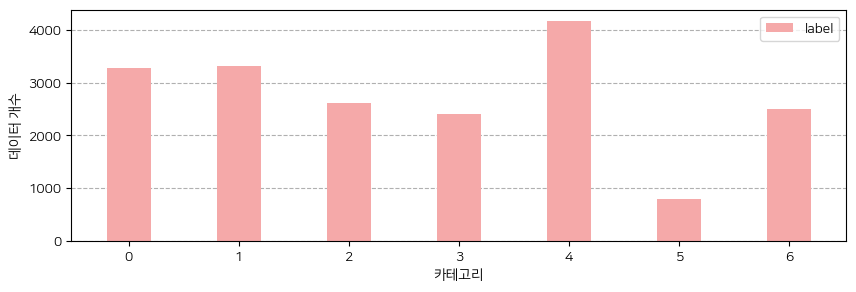

In [94]:
train_part = train_df[train_df['publisher']=='아시아경제']
fig, axes = plt.subplots(figsize=(10,3))
plt.grid(visible=True, axis='y', linestyle='--', zorder=0)
counter = Counter(train_part.target)
counter = dict(sorted(counter.items()))
x = list(counter.keys())[::-1]
y = list(counter.values())[::-1]
print(len(x))
bar_width = 0.4
index = np.arange(len(x))
b1 = plt.bar(x, y, bar_width, color='#F5A9A9', label='label', zorder=2)
plt.xlabel('카테고리', size = 10)
plt.ylabel('데이터 개수', size = 10)
plt.legend()
plt.show()


In [111]:
train_part[(train_part['text'].str.contains(r"월")) & (train_part['target']==0 )].head()
# train_part.loc[[train_part['text'].str.contains(r"월") and train_part['target']==2]].head()

,ID,text,target,date,publisher
197525,NPRW2200000004.879,언팩 앞두고…4개월된 갤럭시Z폴드2 지원금도 상향 최대 55만원,0,20210106,아시아경제
197532,NPRW2200000004.6297,반도체 슈퍼 사이클 시작되나…1월 D램 고정가 8개월만에 반등,0,20210130,아시아경제
198092,NPRW2200000004.70511,S펜 품은 갤럭시 S22… 이번엔 2월 언팩,0,20211108,아시아경제
198144,NPRW2200000004.13376,비수기 1월 세계 반도체 매출 400억弗 첫 돌파…장기 호황 신호탄?,0,20210302,아시아경제
198418,NPRW2200000004.45121,카카오스타일 지그재그 6월 거래액 900억원 달성,0,20210708,아시아경제
